Conservation laws for mirror descent applied to NMF.
----

This is the code to reproduce the numerical simulation of the paper

> _Keep the Momentum: Conservation Laws beyond Gradient Flows_

In [ ]:
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import progressbar
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Load the MNIST dataset
mnist_train = MNIST(root='./data', train=True, download=True, transform=ToTensor())
mnist_test = MNIST(root='./data', train=False, download=True, transform=ToTensor())
# Filter out only the images that correspond to the digit 0
train_zeros = [img for img, label in mnist_train if label == 0]
test_zeros = [img for img, label in mnist_test if label == 0]
# Concatenate train and test datasets
Y = train_zeros + test_zeros
# Convert list of images to a tensor of size (n,p0*p0)
Y = torch.stack(Y).squeeze()
n,p0,_ = Y.shape
p = p0*p0
Y = Y.reshape( n, p ).to(device) + .001 # shift a bit away from 0
print(p0)

100%|██████████| 9912422/9912422 [00:00<00:00, 85518400.79it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 111748795.04it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28854205.52it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18622217.76it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Here we aim at solving
$$
  \min_{U\geq 0, V\geq 0} f(U,V) := \|UV^\top - Y\|^2
$$
and we store $x=(U,V^\top) \in \mathbb{R}^{(n+p) \times r}$

We consider the second order variable metric ODE
$$
	\mu \ddot x + \nu \dot x = -H( \mu \dot x + \nu x ) \nabla f(x)
$$
For instance on can use $\mu=1$ and $\nu=\tau$ if one does not aim at gradient flows, and $\mu=0, \nu=1$ for gradient flows.
To ensure non-negativity constraints, we select here $H(z) v=z \odot v$, which corresponds to a mirror descent flow.

The ODE can be discretized as
$$
	  \mu ( x(t+1) + x(t-1) - 2 x(t) ) / \delta^2 + \nu ( x(t+1) - x(t) ) / \delta = - H_t \nabla f(x(t))
$$
where
$$
  H_t := H( \mu (x(t)-x(t-1))/\delta + \nu x(t) ),
$$
so that
$$
	[\nu + \mu/\delta] x(t+1) - [ \nu + 2 \mu/\delta  ] x(t)
  + \mu/\delta  x(t-1) = -\delta H_t \nabla f(x(t))
$$
so
$$
	[\nu + \mu/\delta] x(t+1)  = [\nu + \mu/\delta] x(t) + \mu/\delta ( x(t) - x(t-1) ) - \delta H_t \nabla f(x(t))
$$

This can thus be re-written as
$$
    x(t+1) = x(t) - \alpha H_t \nabla f(x(t)) + \beta (x(t)-x(t-1))
$$
set $\beta=0$ to recover gradient descent and $0 \leq \beta \leq 1$ ($\beta=1$ is pure momentum). So that one has the following remapping of parameters
$$
	\alpha = \frac{\delta}{\nu + \mu/\delta}
  \quad\text{and}\quad
	\beta =  \frac{ \mu/\delta }{ \nu + \mu/\delta } =
  \frac{\mu}{ \delta \nu + \mu} \leq 1
$$

Training: 100% |###############################################| Time:  0:00:02
Training: 100% |###############################################| Time:  0:00:02
Training: 100% |###############################################| Time:  0:00:02
Training: 100% |###############################################| Time:  0:00:02


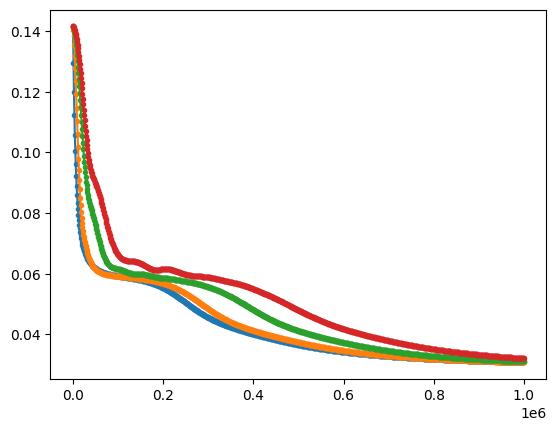

In [ ]:
# Initialize parameters
r = 10  # rank for the factorization

# KL
def myloss(X,Y): return torch.mean( X * torch.log(X/Y) - X + Y )
# L2
def myloss(X,Y): return torch.mean( (X - Y) ** 2 )

Tmax = 1000000
test_type='step_size'
test_type='momentum'

Tmax = 1000000.0

if test_type=='step_size':
  # Testing step size
  delta_list = Tmax/150 * torch.tensor( [.1, .5, 1] )
  mu_list = torch.zeros(len(delta_list)) # + 10000  # uncomment if you want no momentum
  nu_list = torch.ones(len(delta_list))
  Col = [np.array([1, 0, 0]), np.array([0, 0, 1])] # color used for display
elif test_type=='momentum':
  # Testing momentum
  mu_list = torch.tensor([0, 1, 5, 10])*10000.0;
  delta_list = Tmax/1000 * torch.ones(len(mu_list)) # step size
  nu_list = torch.ones(len(mu_list))
  Col = [np.array([1, 0, 1]), np.array([0, 1, 0])] # color used for display

geometry = 'linear'
geometry = 'mirror'

H_GF_list = [] # to stored conservation laws
H_Mom_list = []
Loss_list = []
# Randomly initialize U and V, x=[U;V], and scale them
x0 = torch.rand(n+p, r, device=device)
x0[:n,] = x0[:n,] / torch.norm(x0[:n,]) * torch.sqrt( torch.norm(Y) )
x0[n:,] = x0[n:,] / torch.norm(x0[n:,]) * torch.sqrt( torch.norm(Y) )

for it in range(len(delta_list)):
  mu = mu_list[it]
  nu = nu_list[it]
  delta = delta_list[it]
  # conversion to discrete parameters
  alpha = delta / (nu + mu/delta)
  beta = mu/( delta * nu + mu )
  # number of iterations of the descent to reach Tmax
  niter = ( Tmax/delta ).int().item()

  x = x0.clone()
  x.requires_grad = True
  # Previous U,V (for momentum, initialized with 0 speed)
  xp = x.detach()

  widgets = ['Training: ', progressbar.Percentage(), ' ',
            progressbar.Bar(), ' ', progressbar.ETA()]
  bar = progressbar.ProgressBar(maxval=niter, widgets=widgets).start()
  loss_list = torch.zeros(niter, device=device)

  # gradient flow preserved quantities
  if geometry=='linear':
    H_GF = torch.zeros(r*r,niter)
    H_Mom = torch.zeros(r*r,niter) # momentum flow preserved quantities
  elif geometry=='mirror':
    H_GF = torch.zeros(r,niter)
    H_Mom = torch.tensor([])

  # Gradient Descent
  for epoch in range(niter):
    # Forward pass: Compute predicted Y
    loss = myloss( x[:n,:] @ x[n:,:].T, Y )
    # Zero gradients, perform a backward pass, and update the weights.
    loss.backward()
    with torch.no_grad():
      # variable metric
      if geometry=='linear':
        Hx = torch.ones(n+p, r, device=device) # no metric
      elif geometry=='mirror':
        Hx = mu/delta * (x-xp) + nu * x
      # update rule
      x1 = x.detach().clone() # bookeeping
      x -=  alpha * Hx * x.grad - beta * (x-xp)
      xp = x1 # update previous step
      # Manually zero the gradients after updating weights
      x.grad.zero_()
      # conserved quantities for GF
      U = x[:n,:]
      V = x[n:,:]
      dU = ( x[:n,:] - xp[:n,:] ) / delta # derivative in time
      dV = ( x[n:,:] - xp[n:,:] ) / delta
      if geometry=='linear':
        H_GF[:,epoch] = ( U.T@U - V.T@V ).flatten()
        # TODO : conserved quantities for momentum
      elif geometry=='mirror':
        H_GF[:,epoch] = U.sum(axis=0) - V.sum(axis=0)
    loss_list[epoch] = loss.item()
    bar.update(epoch + 1)

  bar.finish()
  H_GF_list.append(H_GF.detach())
  H_Mom_list.append(H_Mom.detach())
  Loss_list.append(loss_list)
  plt.plot(torch.linspace(0,Tmax,niter), loss_list.cpu(), '.-');


Display loss evolution.

In [ ]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

plt.figure(figsize=(3, 2))
ax = plt.gca()
for it in range(len(delta_list)):
  H = Loss_list[it].cpu()
  niter = len(H)
  c = (1.0-it/len(delta_list))*Col[0] + it/len(delta_list)*Col[1]
  lgd_str = 'NMF, '
  if mu_list.std()>0:
    lgd_str += 'Influence of $\\mu$'
  if nu_list.std()>0:
    lgd_str += 'Influence of $\\nu$'
  if delta_list.std()>0:
    lgd_str += 'Influence of $\\delta$'
  plt.plot(torch.linspace(0,1,niter), H, color=c)
ax.set_ylabel('Loss')
ax.set_xlabel('time t')
plt.title(lgd_str)
cmap = LinearSegmentedColormap.from_list('custom_colormap', [Col[0], Col[1]])
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
sm.set_array([])
plt.colorbar(sm, ax=ax, orientation='vertical')
plt.savefig('nmf_loss.pdf', format='pdf')

Display conservation laws evolution.

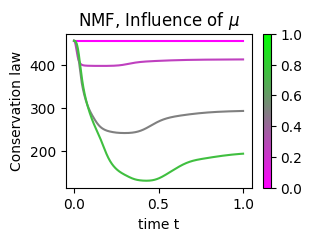

In [ ]:
plt.figure(figsize=(3, 2))
ax = plt.gca()
for it in range(len(delta_list)):
  H = H_GF_list[it].cpu()
  niter = H.shape[-1]
  c = (1.0-it/len(delta_list))*Col[0] + it/len(delta_list)*Col[1]
  lgd_str = 'NMF, '
  if mu_list.std()>0:
    lgd_str += 'Influence of $\\mu$'
    #lgd_str += f'$\\mu={mu_list[it]/max(mu_list):.1f}$'
  if nu_list.std()>0:
    lgd_str += 'Influence of $\\nu$'
    # gd_str += f'$ \\nu={nu_list[it]/max(nu_list):.1f}$'
  if delta_list.std()>0:
    lgd_str += 'Influence of $\\delta$'
  plt.plot(torch.linspace(0,1,niter), H[k,:].T, color=c)
ax.set_ylabel('Conservation law')
ax.set_xlabel('time t')
plt.title(lgd_str)
# plt.legend();
cmap = LinearSegmentedColormap.from_list('custom_colormap', [Col[0], Col[1]])
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
sm.set_array([])
plt.colorbar(sm, ax=ax, orientation='vertical')
plt.savefig('nmf_laws.pdf', format='pdf')

Display the dataset.

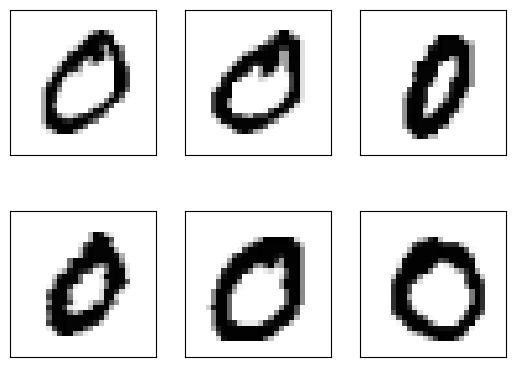

In [ ]:
for num in range(6):
  I = torch.reshape( -Y[num,:], [p0,p0] )
  ax = plt.subplot(2,3,num+1)
  plt.imshow(I.detach().cpu(), cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
plt.savefig('nmf_input.pdf', format='pdf')

Display the NMF factors.

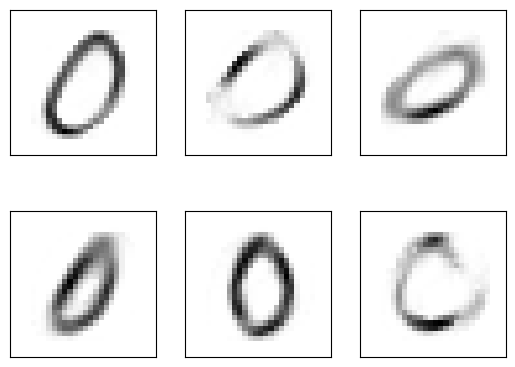

In [ ]:
for num in range(min(6,r)):
  I = torch.reshape( V[:,num], [p0,p0] )
  ax = plt.subplot(2,3,num+1)
  plt.imshow(-I.detach().cpu(), cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
plt.savefig('nmf_factors.pdf', format='pdf')